<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [1]:
import pandas as pd
import numpy as np
import PIL
import cv2 as cv
from keras import models, layers, callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/common.py" -O "common.py"
from common import *

--2020-01-27 16:37:04--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/common.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4100 (4.0K) [text/plain]
Saving to: ‘common.py’

common.py           100%[===================>]   4.00K  --.-KB/s    in 0s      

2020-01-27 16:37:04 (100 MB/s) - ‘common.py’ saved [4100/4100]



In [4]:
!cp "./drive/My Drive/sudoku_acquisition_output.bz2" "./sudoku_acquisition_output.bz2"
acquisition_output = pd.read_pickle("./sudoku_acquisition_output.bz2")
acquisition_output

,input_image,input_digits,input_classes,training
input_filename,,,,
./v2_train/image169.jpg,"[[[164, 161, 118], [164, 161, 118], [164, 161,...","[[8, 3, 0, 0, 0, 7, 9, 0, 0], [0, 0, 0, 0, 3, ...","[[1, 1, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 1, ...",False
./v2_train/image72.jpg,"[[[169, 168, 147], [169, 168, 147], [169, 168,...","[[0, 7, 1, 9, 0, 2, 0, 5, 0], [0, 0, 0, 0, 0, ...","[[0, 1, 1, 1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, ...",False
./v2_train/image1066.jpg,"[[[147, 143, 147], [147, 142, 146], [146, 142,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 6, 0, 1, 5, ...","[[1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 1, ...",True
./v2_train/image1087.jpg,"[[[47, 41, 41], [47, 43, 42], [49, 45, 42], [4...","[[0, 0, 2, 0, 0, 9, 1, 0, 5], [0, 8, 0, 7, 0, ...","[[0, 0, 1, 0, 0, 1, 1, 0, 1], [0, 1, 0, 1, 0, ...",True
./v2_train/image204.jpg,"[[[153, 146, 92], [154, 147, 95], [156, 148, 9...","[[0, 1, 3, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 4, ...","[[0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, ...",False
...,...,...,...,...
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165358878.jpg,"[[[78, 76, 79], [77, 75, 78], [76, 74, 77], [7...","[[2, 4, 7, 9, 9, 4, 7, 6, 1], [8, 7, 6, 2, 6, ...","[[2, 2, 2, 2, 2, 2, 1, 2, 1], [1, 2, 2, 2, 2, ...",True
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165329872.jpg,"[[[133, 127, 105], [131, 125, 103], [131, 125,...","[[2, 4, 7, 9, 9, 4, 7, 6, 1], [8, 7, 6, 2, 6, ...","[[2, 2, 2, 2, 2, 2, 1, 2, 1], [1, 2, 2, 2, 2, ...",True
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165402379.jpg,"[[[50, 50, 50], [51, 51, 51], [50, 50, 50], [4...","[[2, 4, 7, 9, 9, 4, 7, 6, 1], [8, 7, 6, 2, 6, ...","[[2, 2, 2, 2, 2, 2, 1, 2, 1], [1, 2, 2, 2, 2, ...",True


In [5]:
!cp "./drive/My Drive/sudoku_extraction_output.bz2" "./sudoku_extraction_output.bz2"
extraction_output = pd.read_pickle("./sudoku_extraction_output.bz2")
extraction_output

cell_image
input_filename                                     cell_row cell_col                                                   
./v2_train/image1066.jpg                           0        0         [[[81, 77, 76], [56, 51, 51], [51, 47, 46], [5...
                                                            1         [[[49, 45, 43], [50, 46, 44], [53, 49, 47], [5...
                                                            2         [[[55, 49, 50], [56, 50, 51], [57, 53, 51], [5...
                                                            3         [[[50, 47, 46], [50, 46, 45], [51, 47, 46], [5...
                                                            4         [[[55, 50, 52], [57, 51, 54], [58, 52, 55], [5...
...                                                                                                                 ...
./sudoku_dataset_1024/train_247994761_full/IMG_... 8        4         [[[173, 167, 174], [173, 168, 174], [173, 168,...
                                                            5         [[[179, 174, 180], [175, 170, 176], [174, 169,...
                                                            6         [[[161, 156, 162], [165, 160, 166], [170, 165,...
                                                            7         [[[178, 173, 179], [177, 172, 178], [174, 169,...
                                                            8         [[[154, 152, 157], [115, 113, 118], [142, 140,...

[17658 rows x 1 columns]

In [6]:
dataset = extraction_output.copy()
dataset["input_digit"] = [acquisition_output.loc[filename]["input_digits"][row][col] for filename, row, col in extraction_output.index]
dataset["input_class"] = [acquisition_output.loc[filename]["input_classes"][row][col] for filename, row, col in extraction_output.index]
dataset["training"] = [acquisition_output.loc[filename]["training"] for filename, _, _ in extraction_output.index]
dataset

cell_image  ...  training
input_filename                                     cell_row cell_col                                                     ...          
./v2_train/image1066.jpg                           0        0         [[[81, 77, 76], [56, 51, 51], [51, 47, 46], [5...  ...      True
                                                            1         [[[49, 45, 43], [50, 46, 44], [53, 49, 47], [5...  ...      True
                                                            2         [[[55, 49, 50], [56, 50, 51], [57, 53, 51], [5...  ...      True
                                                            3         [[[50, 47, 46], [50, 46, 45], [51, 47, 46], [5...  ...      True
                                                            4         [[[55, 50, 52], [57, 51, 54], [58, 52, 55], [5...  ...      True
...                                                                                                                 ...  ...       ...
./sudoku_dataset_1024/train_247994761_full/IMG_... 8        4         [[[173, 167, 174], [173, 168, 174], [173, 168,...  ...      True
                                                            5         [[[179, 174, 180], [175, 170, 176], [174, 169,...  ...      True
                                                            6         [[[161, 156, 162], [165, 160, 166], [170, 165,...  ...      True
                                                            7         [[[178, 173, 179], [177, 172, 178], [174, 169,...  ...      True
                                                            8         [[[154, 152, 157], [115, 113, 118], [142, 140,...  ...      True

[17658 rows x 4 columns]

# Introduction

As per the last step we now have images of all Sudoku cells.
Within each image there is either a digit from 1 to 9 or it is empty (at least we assume so).
Our Sudoku reader has to classify these images and bring them in a suitable format before we can use a Sudoku solver to solve the actual puzzle problem. 

![Recognition Visualization](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/recognition.png?raw=true)

# Splitting dataset into train and test subsets

In the acquistion step we already labelled all input images as whether they should be used for *training* or *testing*/*validation*.
This is necessary as we want to know whether or not our solution actually works for other input images we have not looked at before.

## Train subset

Images that should be used for training purposes are labelled with `training = True`.

In [10]:
train = dataset[dataset["training"] == True]
print("Training dataset contains %d samples!" % len(train))

Training dataset contains 10449 samples!


Each image is labelled with two numbers ($x$, $y$). 
The number $x$ indicates the contained digit and the number $y$ indicates whether this digit is handwritten ($y=2$) or not ($y=1$).
If a cell is empty, then its corresponding label will be ($0$, $0$). 

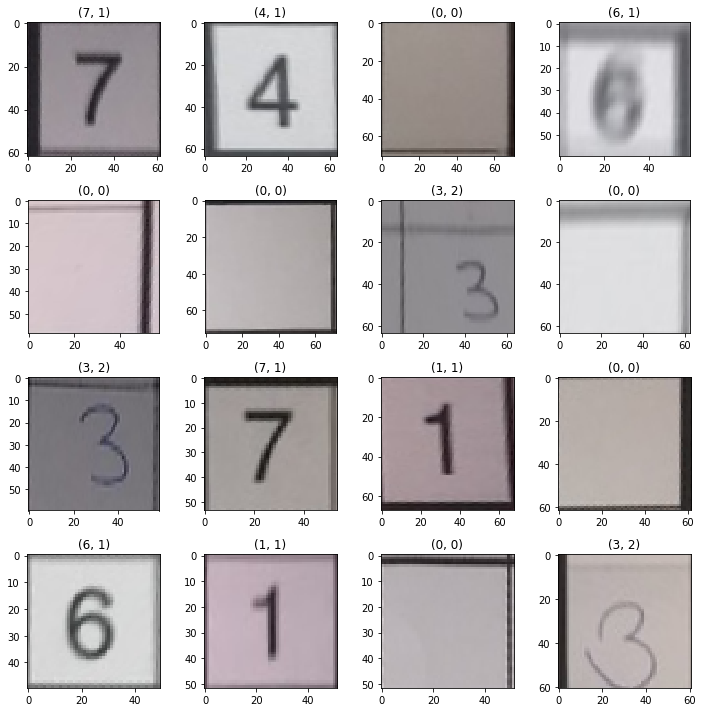

In [15]:
show_images(train["cell_image"], list(zip(train["input_digit"], train["input_class"])), n_samples=16, scaling=(2.5, 2.5))

## Test subset

Images that should be used for testing/validation purposes are labelled with `training = False`.

In [16]:
test = dataset[dataset["training"] == False]
print("Testing dataset contains %d samples!" % len(test))

Testing dataset contains 7209 samples!


Each image is labelled with two numbers ($x$, $y$). 
The number $x$ indicates the contained digit and the number $y$ indicates whether this digit is handwritten ($y=2$) or not ($y=1$).
If a cell is empty, then its corresponding label will be ($0$, $0$). 

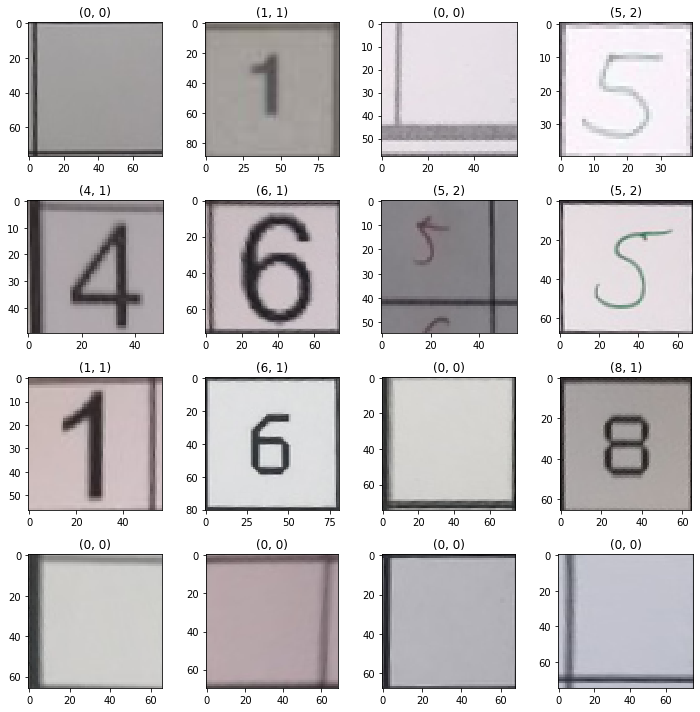

In [17]:
show_images(test["cell_image"], list(zip(test["input_digit"], test["input_class"])), n_samples=16, scaling=(2.5, 2.5))

# Recognize digits using neural networks

We had only limited success with classic means of image recognition like *template matching* so we decided to use *artifical neural networks* for the classification task.
In the following we are discussing different possible network architectures and training methods.
We are using the *Keras* library, which enables us to easily define and train deep neural networks (including convolutional neural networks).

## Plain MNIST

The *MNIST database of handwritten digits* is a very popular dataset for machine learning classification tasks.
It contains a large number of 28-by-28 pixel grayscale images of handwritten digits and the corresponding labels from 0 to 9.
Maybe, if we train a neural network on this dataset, this network is then able to also correctly recognize computer generated digits as they usually occur in Sudoku puzzles.

### Acquire dataset

The train and test datasets can easily be acquired using the `keras.datasets.mnist.load_data()` method. 

In [18]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [19]:
print("Train:", mnist_x_train.shape, mnist_y_train.shape)
print("Test:", mnist_x_test.shape, mnist_y_test.shape)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


Neural networks in general work better with normalized data.
For this reason we scale the 8-bit grayscale values that range from 0 to 255 to a 32-bit float ranging from 0 to 1.

In [0]:
mnist_x_train = mnist_x_train.astype("float32") / 255.0
mnist_x_test = mnist_x_test.astype("float32") / 255.0

As we plan on using convolutional neural networks (CNNs) we must reshape the data to include a third (or fourth) dimension.
The neural network input data is now shaped as follows: (n_samples, width=28, height=28, channels=1)

In [0]:
mnist_x_train = mnist_x_train.reshape(-1, 28, 28, 1)
mnist_x_test = mnist_x_test.reshape(-1, 28, 28, 1)

The following shows a small subset of input images.

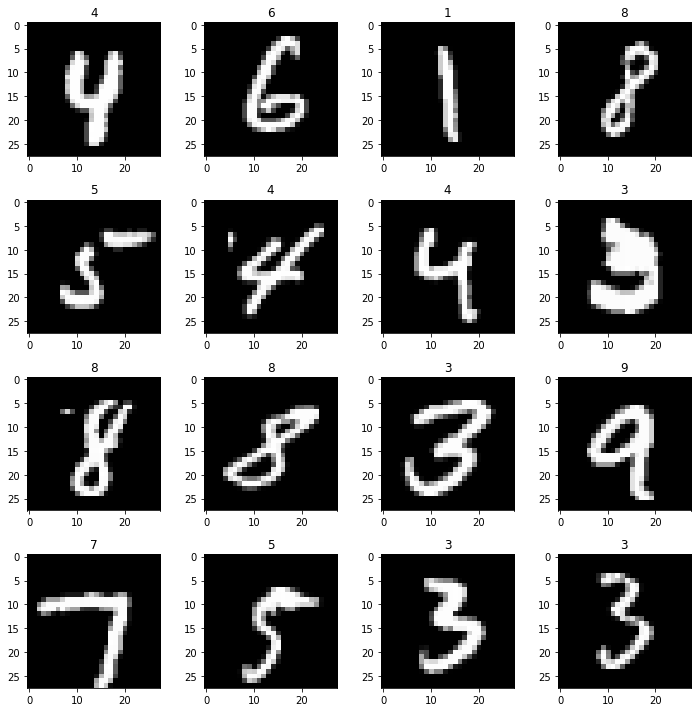

In [22]:
show_images(mnist_x_train, mnist_y_train, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

The architecture itself is inspired by VGGNet (2014).

![VGGNet (2014) architecture](https://miro.medium.com/max/1400/0*V1muWIDnPVwZUuEv.png)

In [27]:
# Input
plainmnist_model = plainmnist_model_input = layers.Input(shape=(28, 28, 1))

# Convolutional Block 1
plainmnist_model = layers.Conv2D(16, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Conv2D(32, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.MaxPool2D()(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dropout(0.25)(plainmnist_model)

# Convolutional Block 2
plainmnist_model = layers.Conv2D(64, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Conv2D(128, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.GlobalMaxPool2D()(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dropout(0.25)(plainmnist_model)

# Fully Connected Block
plainmnist_model = layers.Dense(64, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dense(32, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dense(16, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)

# Output
plainmnist_model = layers.Dense(10, activation="softmax")(plainmnist_model)

plainmnist_model = models.Model(plainmnist_model_input, plainmnist_model, name="plainmnist")
plainmnist_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
plainmnist_model.summary()

Model: "plainmnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_29 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 32)        0

### Fitting the model

We fit the model until the validation loss doesn't improve anymore.
This is achieved using the `EarlyStopping` callback provided by Keras.

In [29]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = plainmnist_model.fit(mnist_x_train, mnist_y_train, validation_data=(mnist_x_test, mnist_y_test), epochs=1000, callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1000
60000/60000 [==============================] - 26s 425us/step - loss: 0.3601 - acc: 0.8955 - val_loss: 0.0511 - val_acc: 0.9848
Epoch 2/1000
60000/60000 [==============================] - 25s 423us/step - loss: 0.1094 - acc: 0.9680 - val_loss: 0.0346 - val_acc: 0.9887
Epoch 3/1000
60000/60000 [==============================] - 25s 416us/step - loss: 0.0779 - acc: 0.9767 - val_loss: 0.0279 - val_acc: 0.9914
Epoch 4/1000
60000/60000 [==============================] - 26s 427us/step - loss: 0.0655 - acc: 0.9802 - val_loss: 0.0299 - val_acc: 0.9908
Epoch 5/1000
60000/60000 [==============================] - 25s 422us/step - loss: 0.0592 - acc: 0.9818 - val_loss: 0.0263 - val_acc: 0.9915
Epoch 6/1000
60000/60000 [==============================] - 25s 424us/step - loss: 0.0517 - acc: 0.9837 - val_loss: 0.0232 - val_acc: 0.9922
Epoch 7/1000
60000/60000 [==============================] - 26s 430us/step - loss: 0.0473 - acc: 0.9859 

In [0]:
plainmnist_model.save("plainmnist_model.h5")
!cp "plainmnist_model.h5" "./drive/My Drive/plainmnist_model.h5"

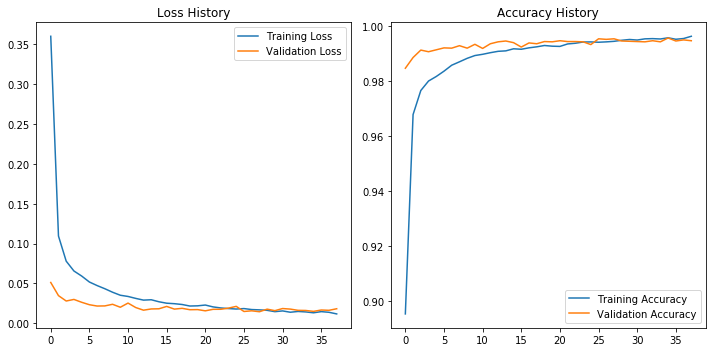

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
plainmnist_model.evaluate(mnist_x_test, mnist_y_test)

10000/10000 [==============================] - 1s 82us/step


[0.014418874411794241, 0.9955]

### Visualizing the model

The following visualizes the intermediate activations of convolutional layers for a random input image.

Visualizing test image 4967


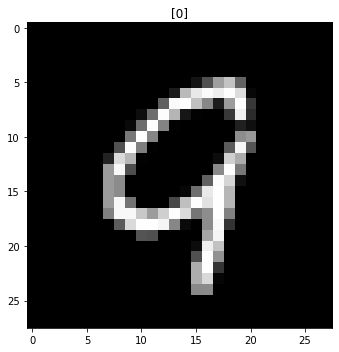

Visualizing layer #1 (conv2d_17)


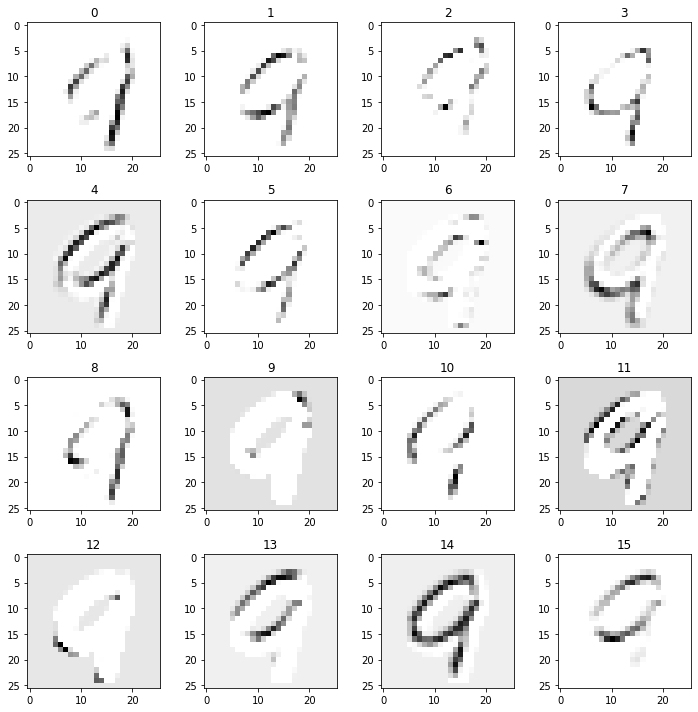

Visualizing layer #3 (conv2d_18)


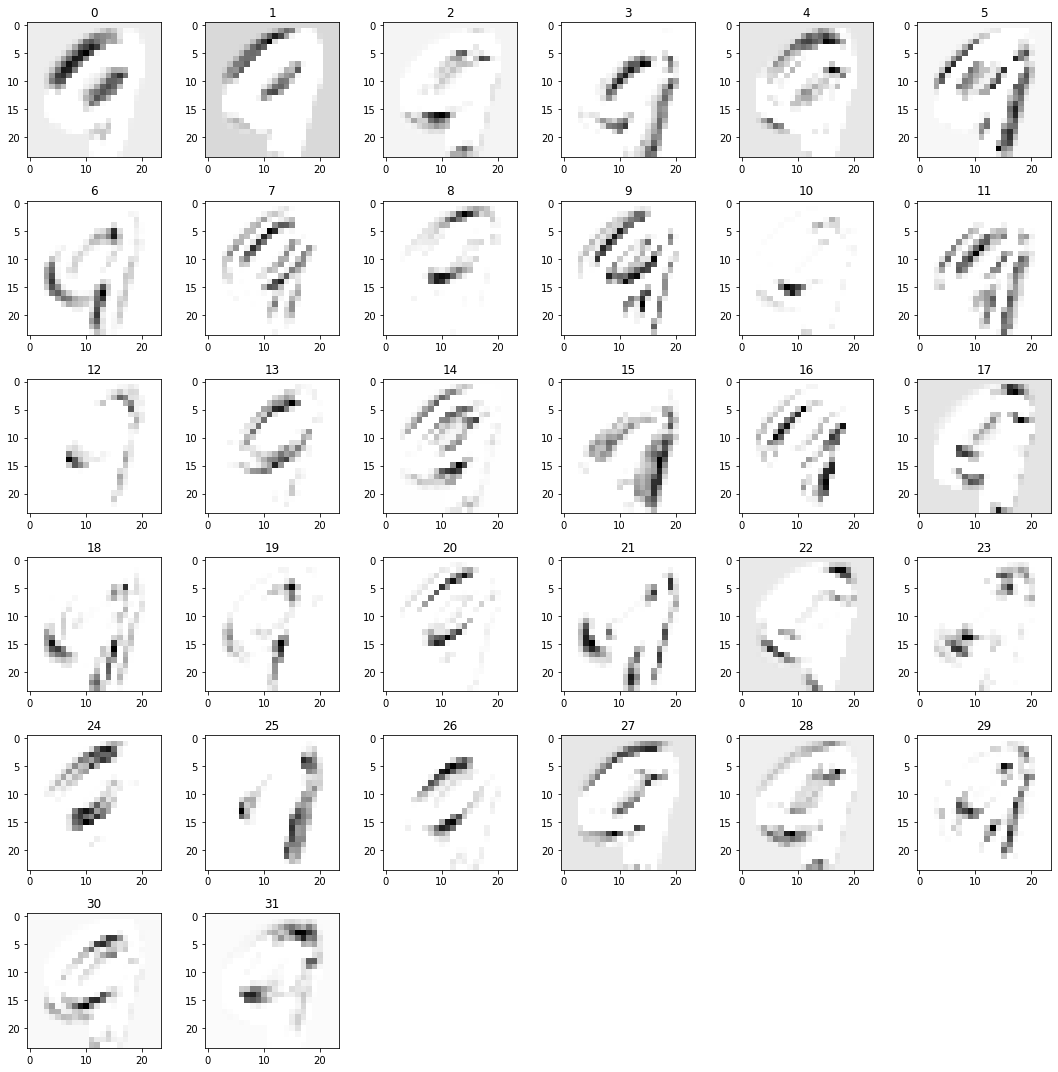

Visualizing layer #7 (conv2d_19)


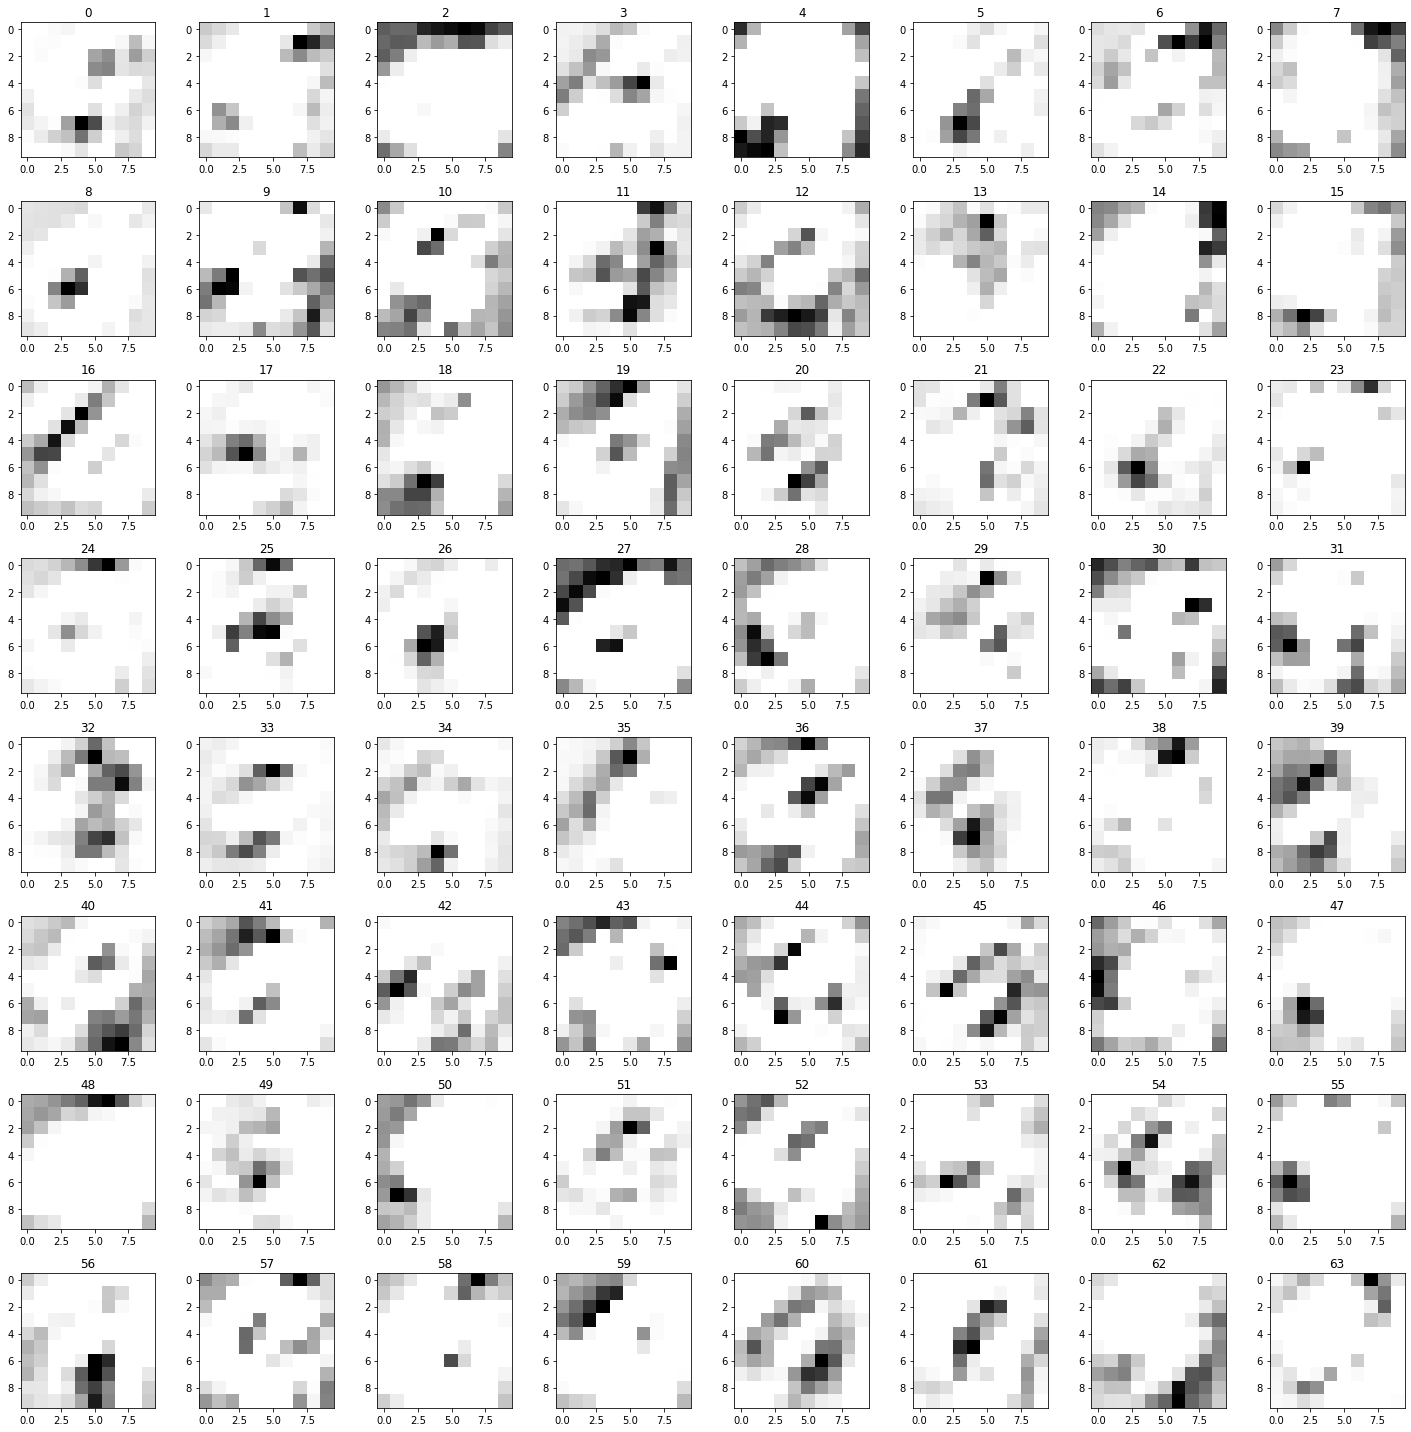

Visualizing layer #9 (conv2d_20)


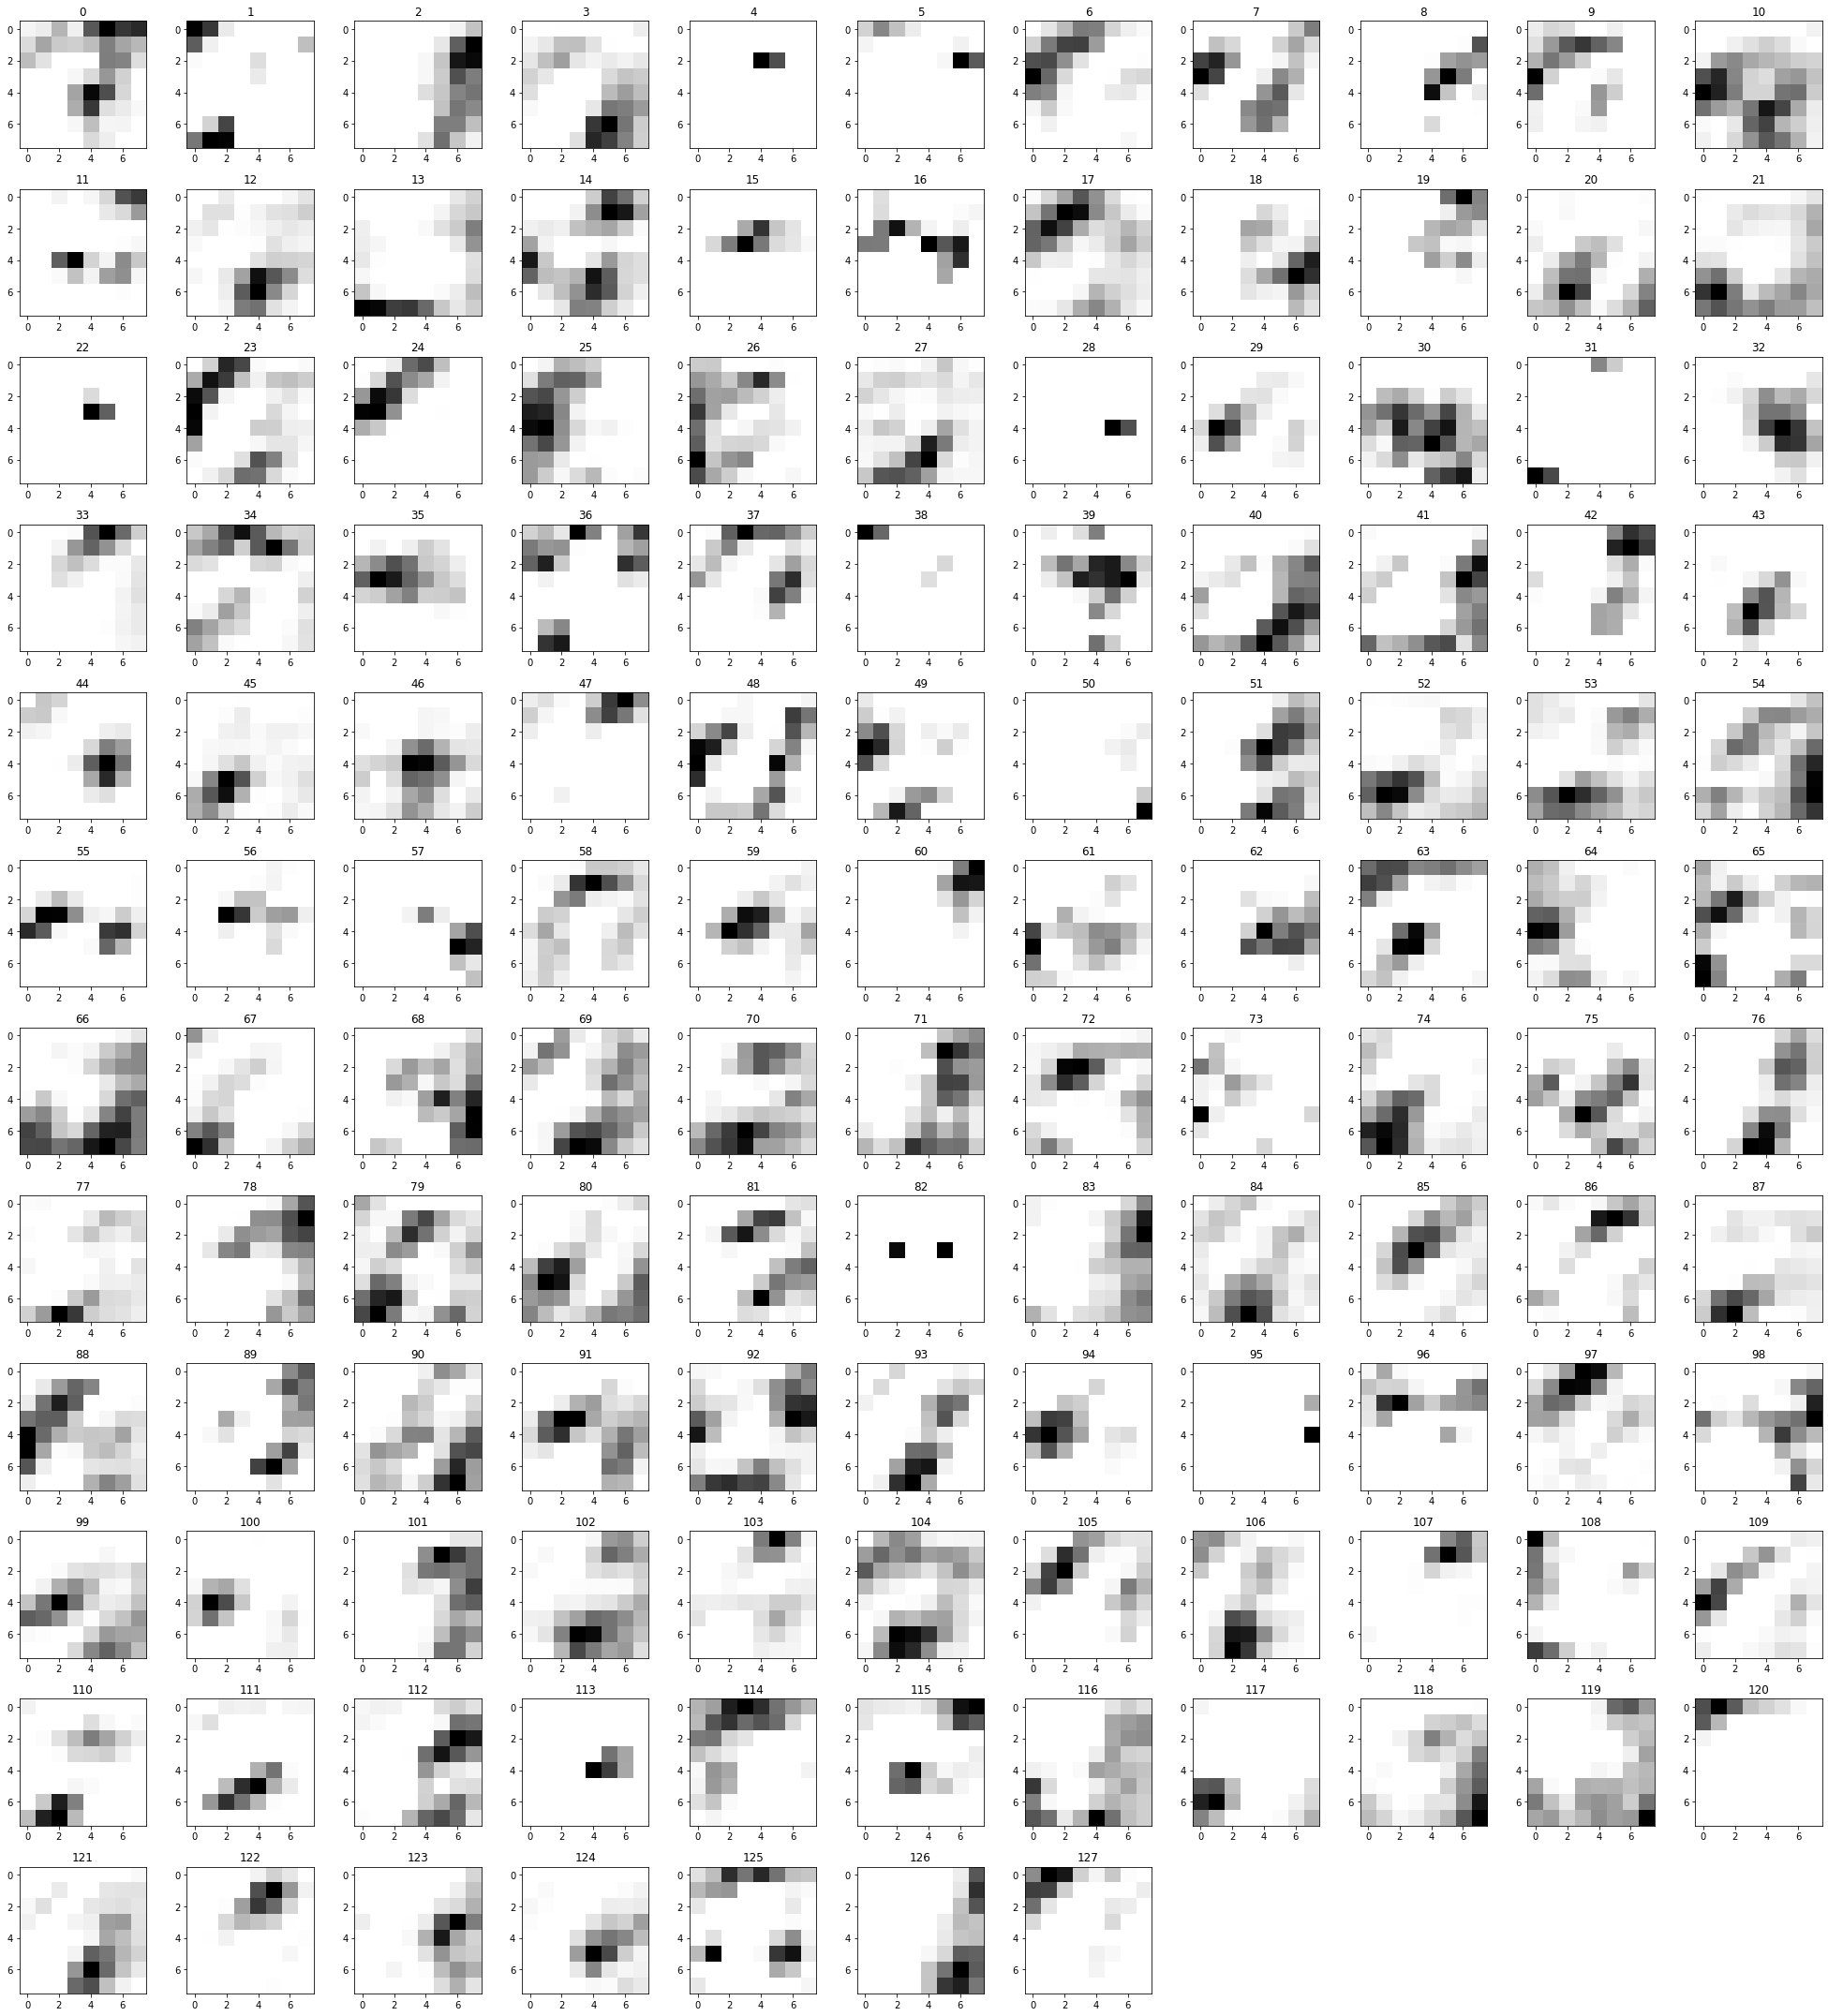

In [33]:
index = random.choice(range(len(mnist_x_test)))
print("Visualizing test image", index)
image = mnist_x_test[index]
show_images([image], cmap="gray")

def nn_get_submodel(model, layer):
  return models.Model(model.input, model.layers[layer].output)

def nn_visualize_layer_activations(model, layer, input):
  submodel = nn_get_submodel(model, layer)
  activations = submodel.predict(np.expand_dims(input, 0))[0]
  activation_channels = np.arange(activations.shape[-1])
  activation_images = [activations[:,:,i] for i in activation_channels]
  show_images(activation_images, activation_channels, cmap="Greys", scaling=(2.5, 2.5), normalize=True)

for i_layer, layer in enumerate(plainmnist_model.layers):
  if layer.name.startswith("conv2d") and len(layer.output.shape) == 4:
    print("Visualizing layer #%d (%s)" % (i_layer, layer.name))
    nn_visualize_layer_activations(plainmnist_model, i_layer, image)

### Evaluating the model

Before we can evaluate the model, we have to preprocess our own samples from the Sudoku dataset so that they are compatible to the network architecture.
This is done by:
- converting from RGB to grayscale
- inverting grayscale values
- normalizing grayscale values to 0..1
- resizing to 28-by-28
- expanding dimensions (-> 3D data)

In [0]:
def plainmnist_preprocess(cell):
  # convert to grayscale
  cell = cv.cvtColor(cell, cv.COLOR_RGB2GRAY)
  # invert:
  cell = 255 - cell
  # normalize:
  cell = cell.astype("float32") / 255.0
  # resize:
  cell = cv.resize(cell, (28, 28), cv.INTER_AREA)
  # expand dims:
  cell = np.expand_dims(cell, axis=2)
  return cell

We also have to make sure we only look at non-zero digits (for now at least), as the MNIST dataset interprets 0 as the actual digit "0", however we interpret 0 as being "empty". 

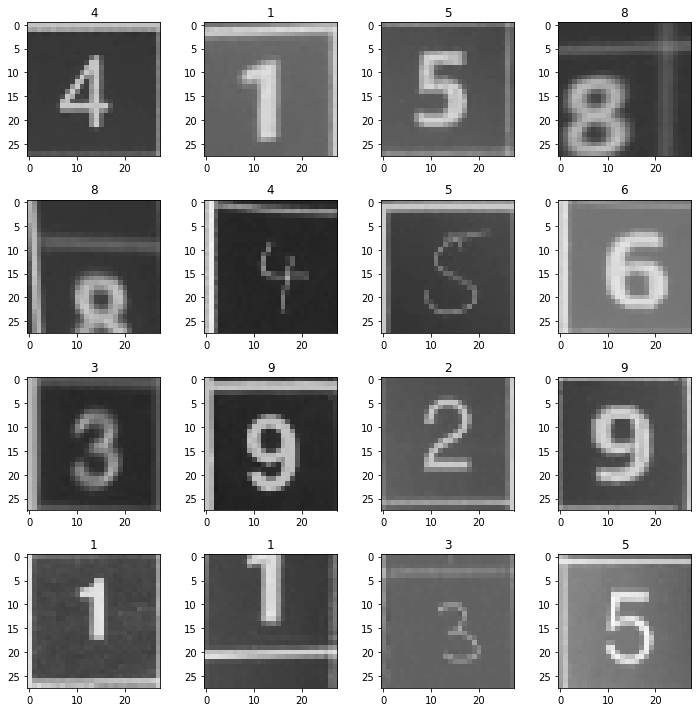

In [39]:
plainmnist_X_train = np.array([plainmnist_preprocess(x) for x in train["cell_image"][train["input_digit"] != 0]])
plainmnist_X_test = np.array([plainmnist_preprocess(x) for x in test["cell_image"][test["input_digit"] != 0]])
plainmnist_Y_train = train["input_digit"][train["input_digit"] != 0].values
plainmnist_Y_test = test["input_digit"][test["input_digit"] != 0].values
show_images(plainmnist_X_train, plainmnist_Y_train, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

Our own test dataset can then be fed into the model.

In [40]:
plainmnist_model.evaluate(plainmnist_X_test, plainmnist_Y_test)

3874/3874 [==============================] - 0s 81us/step


[11.246098895016317, 0.12493546721734641]

In [41]:
plainmnist_Y_pred = plainmnist_model.predict(plainmnist_X_test)
print(classification_report(plainmnist_Y_test, np.argmax(plainmnist_Y_pred, axis=1)))

              precision    recall  f1-score   support

           1       0.12      1.00      0.22       462
           2       0.00      0.00      0.00       425
           3       0.00      0.00      0.00       499
           4       0.31      0.06      0.10       389
           5       0.00      0.00      0.00       394
           6       0.00      0.00      0.00       455
           7       0.00      0.00      0.00       370
           8       0.00      0.00      0.00       421
           9       0.00      0.00      0.00       459

    accuracy                           0.12      3874
   macro avg       0.05      0.12      0.03      3874
weighted avg       0.05      0.12      0.04      3874



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As shown, the network does not really perform well on our own dataset.
This could be due to a number of reason:

- The MNIST dataset contains only handwritten digits wheras we include both handwritten *and* computer generated ones.
- Our images include cell borders that may confuse the network.
- Our images are relatively low contrast and blurry. 

## Augmented MNIST

Obviously the "Plain MNSIT" model did not generalize very well.
One method to improve generalization is to *augment* the training data.
This can be done by shifting, zooming and rotating (within certain bounds) of the images as these operations do not change how an image should be labelled.

### Acquire dataset

The augmented dataset uses the previous MNIST dataset as a basis.
Data augmentation is realized using Keras' `ImageDataGenerator` class.
Additionally we have written custom methods to randomly change brightness and contrast of input images.

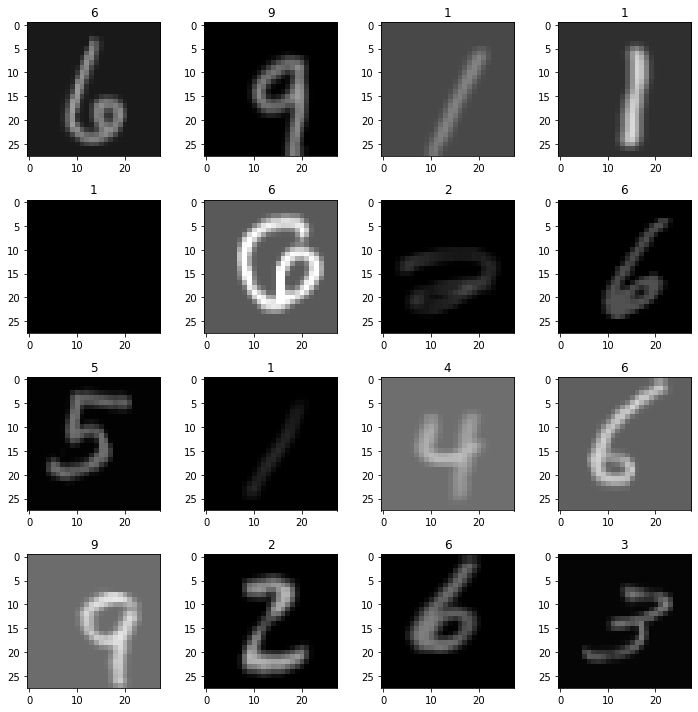

In [43]:
def augmnist_change_brightness(image, factor):
  return image * factor

def augmnist_change_contrast(image, factor):
  return 0.5 + factor * (image - 0.5)

def augmnist_blur(image):
  ksize = np.random.randint(1, 4, size=(2,))
  return cv.blur(src=image, ksize=tuple(ksize))

def augmnist_preprocess(image):
  image = image[:,:,0]
  factor = np.random.rand() * 0.5 + 0.5
  image = augmnist_change_brightness(image, factor)
  factor = np.random.rand() * 0.5 + 0.5
  image = augmnist_change_contrast(image, factor)
  image += np.random.randn() * 0.25
  image = np.clip(image, 0.0, 1.0)
  image = augmnist_blur(image)
  return np.expand_dims(image, axis=2)

generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, shear_range=10.0, preprocessing_function=augmnist_preprocess)
augmnist_generator_train = generator.flow(mnist_x_train, mnist_y_train)
augmnist_generator_test = generator.flow(mnist_x_test, mnist_y_test)
show_images(*augmnist_generator_train[0], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

In [46]:
# Input
augmnist_model = augmnist_model_input = layers.Input(shape=(28, 28, 1))

# Convolutional Block 1
augmnist_model = layers.Conv2D(16, 3, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Conv2D(32, 3, activation="relu")(augmnist_model)
augmnist_model = layers.MaxPool2D()(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dropout(0.25)(augmnist_model)

# Convolutional Block 2
augmnist_model = layers.Conv2D(64, 3, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Conv2D(128, 3, activation="relu")(augmnist_model)
augmnist_model = layers.GlobalMaxPool2D()(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dropout(0.25)(augmnist_model)

# Fully Connected Block
augmnist_model = layers.Dense(64, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dense(32, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dense(16, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)

# Output
augmnist_model = layers.Dense(10, activation="softmax")(augmnist_model)

augmnist_model = models.Model(augmnist_model_input, augmnist_model, name="augmnist")
augmnist_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
augmnist_model.summary()

Model: "augmnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_50 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 32)        0  

### Fitting the model

In [48]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = augmnist_model.fit_generator(augmnist_generator_train, validation_data=augmnist_generator_test, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
1875/1875 [==============================] - 48s 26ms/step - loss: 0.6880 - acc: 0.7838 - val_loss: 0.1381 - val_acc: 0.9583
Epoch 2/1000
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1974 - acc: 0.9395 - val_loss: 0.1001 - val_acc: 0.9683
Epoch 3/1000
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1549 - acc: 0.9516 - val_loss: 0.0749 - val_acc: 0.9764
Epoch 4/1000
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1331 - acc: 0.9584 - val_loss: 0.0694 - val_acc: 0.9768
Epoch 5/1000
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1151 - acc: 0.9636 - val_loss: 0.0571 - val_acc: 0.9805
Epoch 6/1000
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1105 - acc: 0.9650 - val_loss: 0.0548 - val_acc: 0.9823
Epoch 7/1000
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0999 - acc: 0.9680 - val_loss: 0.0534 - val_acc: 0.9818
Epoch 8/1000
1875/1875 [==========

In [0]:
augmnist_model.save("augmnist_model.h5")
!cp "augmnist_model.h5" "./drive/My Drive/augmnist_model.h5"

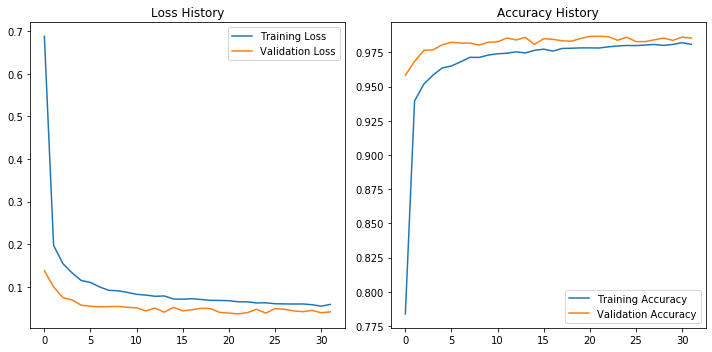

In [50]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
augmnist_model.evaluate_generator(augmnist_generator_test)

[0.04293005475532263, 0.9848]

### Evaluating the model

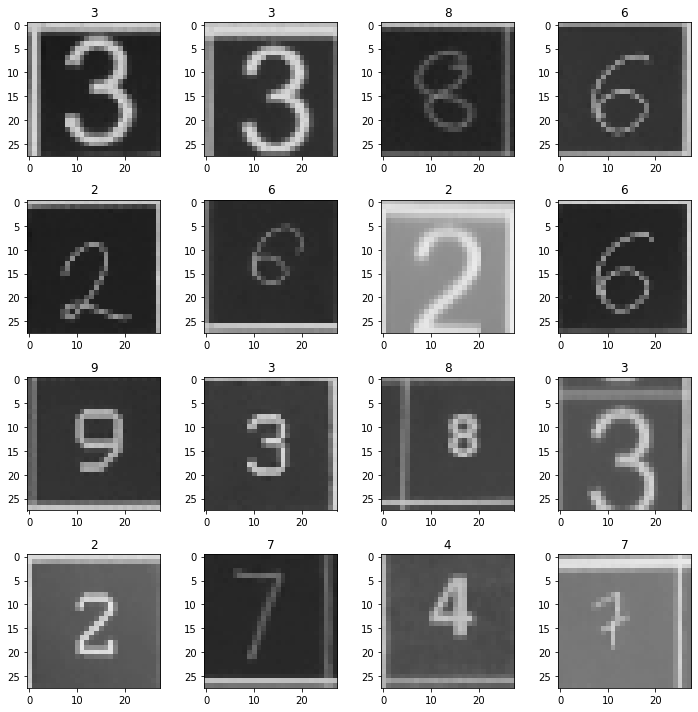

In [52]:
augmnist_X_train = np.array([plainmnist_preprocess(x) for x in train["cell_image"][train["input_digit"] != 0]])
augmnist_X_test = np.array([plainmnist_preprocess(x) for x in test["cell_image"][test["input_digit"] != 0]])
augmnist_Y_train = train["input_digit"][train["input_digit"] != 0].values
augmnist_Y_test = test["input_digit"][test["input_digit"] != 0].values
show_images(augmnist_X_test, augmnist_Y_test, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

In [55]:
augmnist_model.evaluate(augmnist_X_test, augmnist_Y_test)

3874/3874 [==============================] - 0s 86us/step


[1.1620421179127434, 0.7057305110996386]

In [56]:
augmnist_Y_pred = augmnist_model.predict(augmnist_X_test)
print(classification_report(augmnist_Y_test, np.argmax(augmnist_Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.88      0.73      0.80       462
           2       0.65      0.59      0.62       425
           3       0.71      0.85      0.78       499
           4       0.91      0.74      0.82       389
           5       0.46      0.87      0.61       394
           6       0.76      0.59      0.66       455
           7       0.61      0.60      0.60       370
           8       0.90      0.80      0.85       421
           9       0.77      0.57      0.65       459

    accuracy                           0.71      3874
   macro avg       0.67      0.63      0.64      3874
weighted avg       0.74      0.71      0.71      3874



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The "Augmented MNIST" model performs significantly better than the "Plain MNIST" model on our dataset.
Still, an accuracy of about 70% is not enough for a reliable Sudoku solver.
On average about 24 digits per puzzle would be misclassified.

## Sudoku dataset

Obviously we can use our own dataset to train a network.
And that's exactly what we do now.

### Acquire dataset

We use our own dataset for training and prepare it in a similar way to the MNIST images.

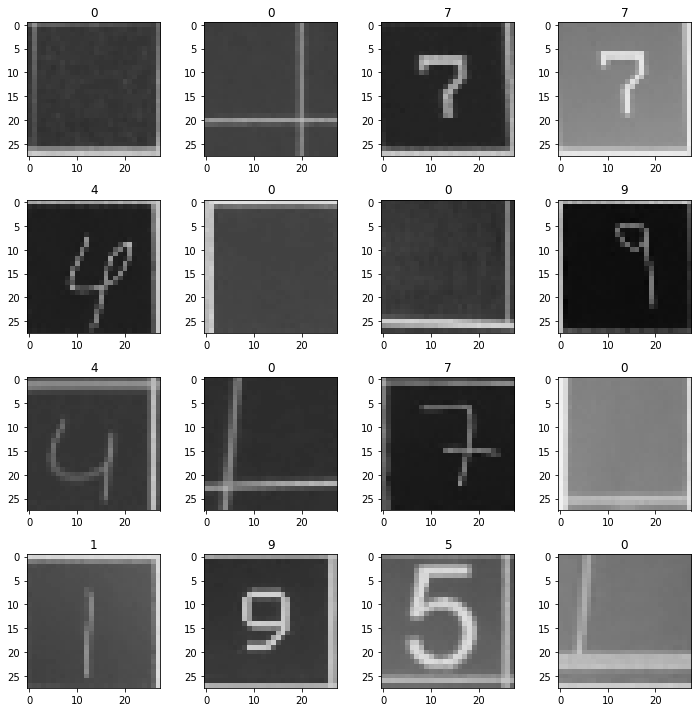

In [57]:
sudnn_X_train = np.array([plainmnist_preprocess(x) for x in train["cell_image"]])
sudnn_X_test = np.array([plainmnist_preprocess(x) for x in test["cell_image"]])
sudnn_Y_train = train["input_digit"].values
sudnn_Y_test = test["input_digit"].values
show_images(sudnn_X_test, sudnn_Y_test, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

Because the previous model architecture liked to overfit we significantly reduced the complexity and number of parameters of this model.

In [58]:
# Input
sudnn_model = sudnn_model_input = layers.Input(shape=(28, 28, 1))

# Convolutional Block 1
sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Conv2D(32, 3, activation="relu")(sudnn_model)
sudnn_model = layers.MaxPool2D()(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Dropout(0.5)(sudnn_model)

# Convolutional Block 2
sudnn_model = layers.Conv2D(32, 3, activation="relu")(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
sudnn_model = layers.GlobalMaxPool2D()(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Dropout(0.5)(sudnn_model)

# Fully Connected Block
# sudnn_model = layers.GaussianNoise(0.1)(sudnn_model)
# sudnn_model = layers.Dense(64, activation="relu")(sudnn_model)
# sudnn_model = layers.BatchNormalization()(sudnn_model)
# sudnn_model = layers.Dense(32, activation="relu")(sudnn_model)
# sudnn_model = layers.BatchNormalization()(sudnn_model)
# sudnn_model = layers.Dense(16, activation="relu")(sudnn_model)
# sudnn_model = layers.BatchNormalization()(sudnn_model)
# sudnn_model = layers.Dropout(0.5)(sudnn_model)

# Output
sudnn_model = layers.Dense(10, activation="softmax")(sudnn_model)

sudnn_model = models.Model(sudnn_model_input, sudnn_model, name="sudnn")
sudnn_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
sudnn_model.summary()

Model: "sudnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_57 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 32)        0     

### Fitting the model

Our dataset contains an unproportional large number of empty cells.
This has to be accounted for when training.
Otherwise the network could fall back on always predicting class 0 and reach an accuracy of 90% with that!
Obviously such predictions are worthless to us.
This problem of an unbalanced dataset can be somewhat alleviated by assigning a lower class weight to the 0 class. 

The `sklearn.utils.class_weight` package contains a method `compute_class_weight(...)` that computes the necessary class weights to counter the effects of an unbalanced dataset.

In [59]:
class_weight = compute_class_weight("balanced", np.unique(sudnn_Y_train), sudnn_Y_train)
class_weight

array([0.25485366, 1.50345324, 1.45125   , 1.56422156, 1.54342688,
       1.53436123, 1.38214286, 1.42745902, 1.60506912, 1.35877763])

In [61]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = sudnn_model.fit(sudnn_X_train, sudnn_Y_train, 
                              validation_data=(sudnn_X_test, sudnn_Y_test), 
                              epochs=1000, callbacks=[early_stopping], 
                              class_weight=class_weight)

Train on 10449 samples, validate on 7209 samples
Epoch 1/1000
10449/10449 [==============================] - 4s 428us/step - loss: 1.5407 - acc: 0.5045 - val_loss: 1.0644 - val_acc: 0.6449
Epoch 2/1000
10449/10449 [==============================] - 3s 332us/step - loss: 0.8200 - acc: 0.7383 - val_loss: 0.7506 - val_acc: 0.7629
Epoch 3/1000
10449/10449 [==============================] - 3s 328us/step - loss: 0.5835 - acc: 0.8185 - val_loss: 0.6113 - val_acc: 0.8101
Epoch 4/1000
10449/10449 [==============================] - 3s 324us/step - loss: 0.4713 - acc: 0.8514 - val_loss: 0.5383 - val_acc: 0.8392
Epoch 5/1000
10449/10449 [==============================] - 3s 320us/step - loss: 0.3958 - acc: 0.8786 - val_loss: 0.5922 - val_acc: 0.8187
Epoch 6/1000
10449/10449 [==============================] - 3s 316us/step - loss: 0.3509 - acc: 0.8925 - val_loss: 0.4177 - val_acc: 0.8867
Epoch 7/1000
10449/10449 [==============================] - 3s 330us/step - loss: 0.3117 - acc: 0.9024 - val_lo

In [0]:
sudnn_model.save("sudnn_model.h5")
!cp "sudnn_model.h5" "./drive/My Drive/sudnn_model.h5"

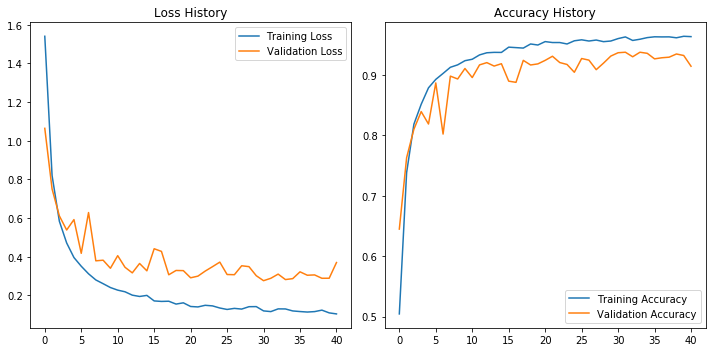

In [63]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
sudnn_model.evaluate(sudnn_X_test, sudnn_Y_test)

7209/7209 [==============================] - 1s 72us/step


[0.27605029568507705, 0.9366070190040228]

### Evaluating the model

In [65]:
sudnn_model.evaluate(sudnn_X_test, sudnn_Y_test)

7209/7209 [==============================] - 1s 71us/step


[0.27605029568507705, 0.9366070190040228]

In [66]:
sudnn_Y_pred = sudnn_model.predict(sudnn_X_test)
sudnn_Y_pred_classes = np.argmax(sudnn_Y_pred, axis=1)
print(classification_report(sudnn_Y_test, sudnn_Y_pred_classes, digits=3))

              precision    recall  f1-score   support

           0      0.985     0.987     0.986      3335
           1      0.801     0.939     0.865       462
           2      0.884     0.899     0.891       425
           3      0.890     0.926     0.908       499
           4      0.932     0.910     0.921       389
           5      0.979     0.711     0.824       394
           6      0.953     0.943     0.948       455
           7      0.858     0.865     0.861       370
           8      0.889     0.948     0.917       421
           9      0.920     0.876     0.897       459

    accuracy                          0.937      7209
   macro avg      0.909     0.900     0.902      7209
weighted avg      0.939     0.937     0.936      7209



#### Correctly classified samples

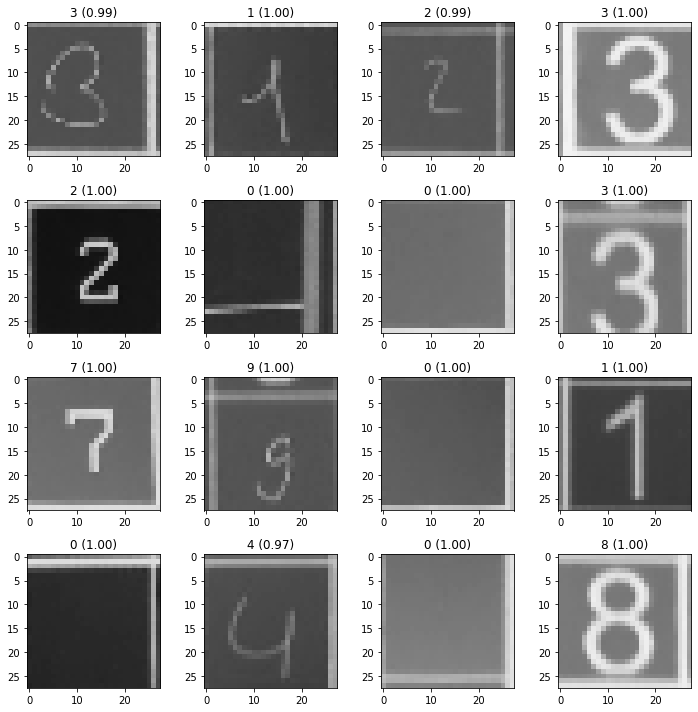

In [67]:
correct_examples = sudnn_Y_pred_classes == sudnn_Y_test
show_images(sudnn_X_test[correct_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in sudnn_Y_pred[correct_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Incorrectly classified samples

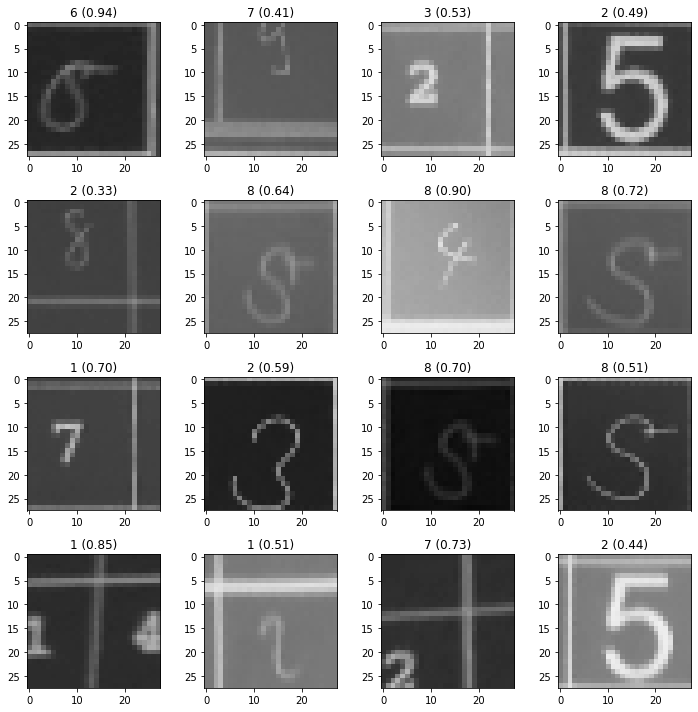

In [68]:
incorrect_examples = sudnn_Y_pred_classes != sudnn_Y_test
show_images(sudnn_X_test[incorrect_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in sudnn_Y_pred[incorrect_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

## Augmented Sudoku dataset

Maybe we can use augmentation once again to improve our accuracy on the test dataset?


### Acquire dataset

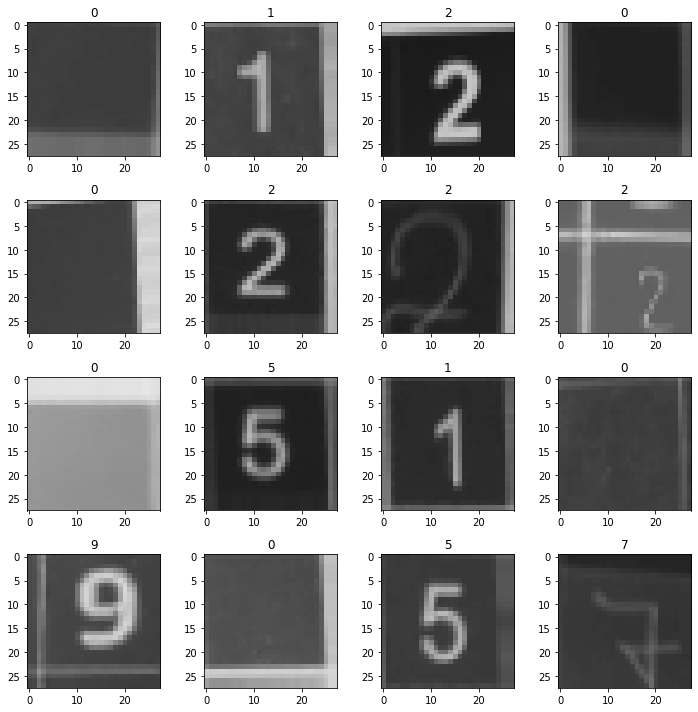

In [69]:
augsud_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                      zoom_range=0.1, shear_range=2.5, rotation_range=2.5)

augsud_train = augsud_generator.flow(sudnn_X_train, sudnn_Y_train)
augsud_X_test = sudnn_X_test
augsud_Y_test = sudnn_Y_test
show_images(*augsud_train[0], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

In [70]:
# Input
augsud_model = augsud_model_input = layers.Input(shape=(28, 28, 1))

# Convolutional Block 1
augsud_model = layers.Conv2D(16, 3, activation="relu")(augsud_model)
augsud_model = layers.BatchNormalization()(augsud_model)
augsud_model = layers.Conv2D(32, 3, activation="relu")(augsud_model)
augsud_model = layers.MaxPool2D()(augsud_model)
augsud_model = layers.BatchNormalization()(augsud_model)
augsud_model = layers.Dropout(0.5)(augsud_model)

# Convolutional Block 2
augsud_model = layers.Conv2D(32, 3, activation="relu")(augsud_model)
augsud_model = layers.BatchNormalization()(augsud_model)
augsud_model = layers.Conv2D(16, 3, activation="relu")(augsud_model)
augsud_model = layers.GlobalMaxPool2D()(augsud_model)
augsud_model = layers.BatchNormalization()(augsud_model)
augsud_model = layers.Dropout(0.5)(augsud_model)

# Fully Connected Block
# augsud_model = layers.GaussianNoise(0.1)(augsud_model)
# augsud_model = layers.Dense(64, activation="relu")(augsud_model)
# augsud_model = layers.BatchNormalization()(augsud_model)
# augsud_model = layers.Dense(32, activation="relu")(augsud_model)
# augsud_model = layers.BatchNormalization()(augsud_model)
# augsud_model = layers.Dense(16, activation="relu")(augsud_model)
# augsud_model = layers.BatchNormalization()(augsud_model)
# augsud_model = layers.Dropout(0.5)(augsud_model)

# Output
augsud_model = layers.Dense(10, activation="softmax")(augsud_model)

augsud_model = models.Model(augsud_model_input, augsud_model, name="augsud")
augsud_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
augsud_model.summary()

Model: "augsud"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_61 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_19 (Dropout)         (None, 12, 12, 32)        0    

### Fitting the model

In [71]:
class_weight = compute_class_weight("balanced", np.unique(sudnn_Y_train), sudnn_Y_train)
class_weight

array([0.25485366, 1.50345324, 1.45125   , 1.56422156, 1.54342688,
       1.53436123, 1.38214286, 1.42745902, 1.60506912, 1.35877763])

In [72]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = augsud_model.fit_generator(augsud_train, 
                                         validation_data=(augsud_X_test, augsud_Y_test), 
                                         epochs=1000, callbacks=[early_stopping], 
                                         class_weight=class_weight)

Epoch 1/1000
327/327 [==============================] - 8s 24ms/step - loss: 1.7924 - acc: 0.4266 - val_loss: 1.1683 - val_acc: 0.6502
Epoch 2/1000
327/327 [==============================] - 5s 16ms/step - loss: 1.0446 - acc: 0.6548 - val_loss: 0.9703 - val_acc: 0.7276
Epoch 3/1000
327/327 [==============================] - 5s 16ms/step - loss: 0.7828 - acc: 0.7530 - val_loss: 0.7066 - val_acc: 0.7812
Epoch 4/1000
327/327 [==============================] - 5s 16ms/step - loss: 0.6297 - acc: 0.7991 - val_loss: 0.6183 - val_acc: 0.8052
Epoch 5/1000
327/327 [==============================] - 5s 16ms/step - loss: 0.5453 - acc: 0.8300 - val_loss: 0.5231 - val_acc: 0.8451
Epoch 6/1000
327/327 [==============================] - 5s 16ms/step - loss: 0.4867 - acc: 0.8464 - val_loss: 0.5081 - val_acc: 0.8399
Epoch 7/1000
327/327 [==============================] - 5s 16ms/step - loss: 0.4395 - acc: 0.8555 - val_loss: 0.5142 - val_acc: 0.8414
Epoch 8/1000
327/327 [==============================] -

In [0]:
augsud_model.save("augsud_model.h5")
!cp "augsud_model.h5" "./drive/My Drive/augsud_model.h5"

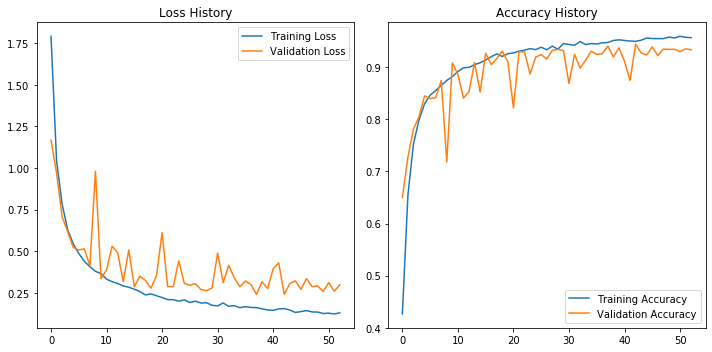

In [75]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### Evaluating the model

In [76]:
augsud_model.evaluate(augsud_X_test, augsud_Y_test)

7209/7209 [==============================] - 1s 182us/step


[0.24065337598923162, 0.9446525176862256]

In [77]:
augsud_Y_pred = augsud_model.predict(augsud_X_test)
augsud_Y_pred_classes = np.argmax(augsud_Y_pred, axis=1)
print(classification_report(augsud_Y_test, augsud_Y_pred_classes, digits=3))

              precision    recall  f1-score   support

           0      0.986     0.993     0.990      3335
           1      0.931     0.846     0.887       462
           2      0.973     0.918     0.944       425
           3      0.965     0.950     0.958       499
           4      0.947     0.925     0.936       389
           5      0.982     0.848     0.910       394
           6      0.971     0.945     0.958       455
           7      0.749     0.951     0.838       370
           8      0.772     0.971     0.860       421
           9      0.957     0.778     0.858       459

    accuracy                          0.945      7209
   macro avg      0.923     0.913     0.914      7209
weighted avg      0.950     0.945     0.945      7209



In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(augsud_Y_test, augsud_Y_pred_classes)

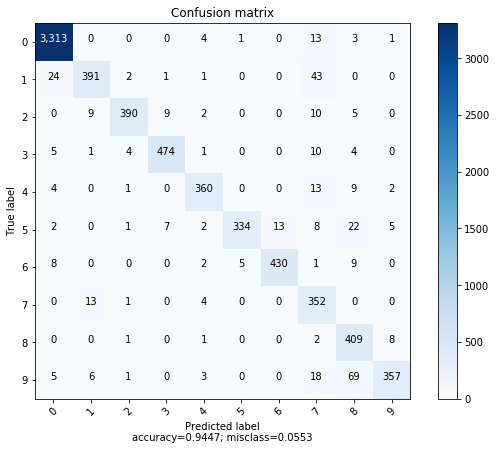

In [88]:
# source: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm, [str(i) for i in range(10)], normalize=False)

#### Correctly classified samples

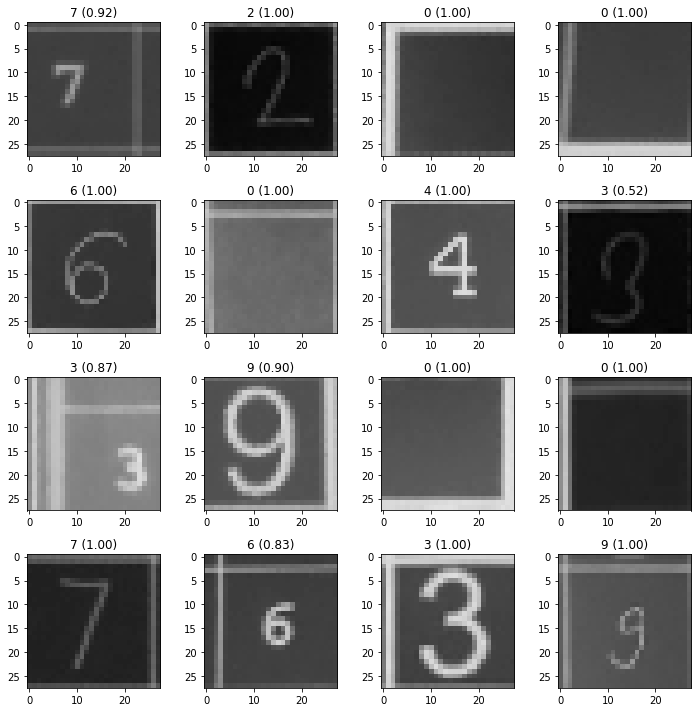

In [92]:
correct_examples = augsud_Y_pred_classes == augsud_Y_test
show_images(augsud_X_test[correct_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in augsud_Y_pred[correct_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Incorrectly classified samples

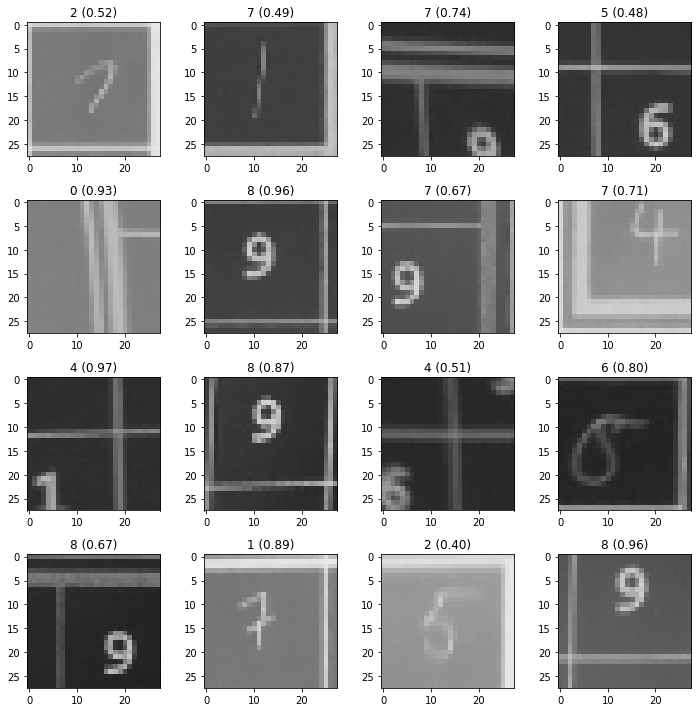

In [91]:
incorrect_examples = augsud_Y_pred_classes != augsud_Y_test
show_images(augsud_X_test[incorrect_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in augsud_Y_pred[incorrect_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

## Transfer Learning

### Acquire dataset

As the dataset for the transfer learning process we use the "Augmented Sudoku dataset".

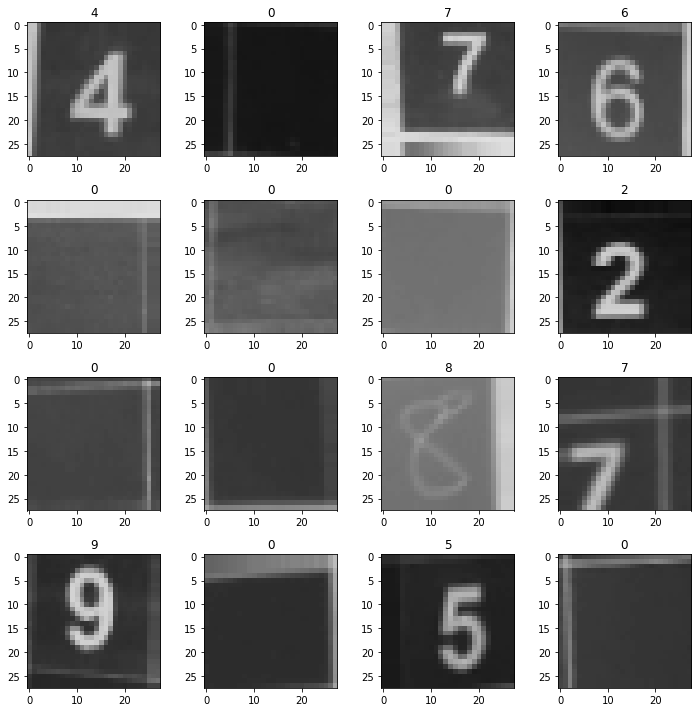

In [98]:
trans_train = augsud_train
trans_X_test, trans_Y_test = sudnn_X_test, sudnn_Y_test
show_images(*trans_train[0], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

The pretrained model is extracted from the "Augmented MNIST" model:
We take all but the last block of fully connected layers from it.

In [101]:
trans_model_pre_input = augmnist_model.get_input_at(0)
trans_model_pre = models.Model(trans_model_pre_input, augmnist_model.layers[-8].output, name="trans_pre")
trans_model_pre.trainable = False
trans_model_pre.summary()

Model: "trans_pre"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_50 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 32)        0 

The output of the pretrained model is fed into a new fully connected layer with size 10.
This layer is then set as the output of the composed model.

In [102]:
trans_model_input = trans_model_pre_input

# Prepend pretrained model
trans_model = trans_model_pre(trans_model_input)

# Fully Connected Block
#trans_model = layers.Dense(8, activation="relu")(trans_model)
#trans_model = layers.BatchNormalization()(trans_model)
#trans_model = layers.Dense(32, activation="relu")(trans_model)
#trans_model = layers.BatchNormalization()(trans_model)
#trans_model = layers.Dense(16, activation="relu")(trans_model)
#trans_model = layers.BatchNormalization()(trans_model)
#trans_model = layers.Dropout(0.5)(trans_model)

# Output
trans_model = layers.Dense(10, activation="softmax")(trans_model)

trans_model = models.Model(trans_model_input, trans_model, name="trans")
trans_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
trans_model.summary()

Model: "trans"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
trans_pre (Model)            (None, 128)               98112     
_________________________________________________________________
dense_36 (Dense)             (None, 10)                1290      
Total params: 99,402
Trainable params: 1,290
Non-trainable params: 98,112
_________________________________________________________________


### Fitting the model

In [103]:
class_weight = compute_class_weight("balanced", np.unique(sudnn_Y_train), sudnn_Y_train)
class_weight

array([0.25485366, 1.50345324, 1.45125   , 1.56422156, 1.54342688,
       1.53436123, 1.38214286, 1.42745902, 1.60506912, 1.35877763])

In [104]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = trans_model.fit_generator(trans_train, 
                                        validation_data=(trans_X_test, trans_Y_test), 
                                        epochs=100, callbacks=[early_stopping], 
                                        class_weight=class_weight)

Epoch 1/100
327/327 [==============================] - 7s 20ms/step - loss: 0.8587 - acc: 0.7337 - val_loss: 0.5712 - val_acc: 0.8351
Epoch 2/100
327/327 [==============================] - 4s 12ms/step - loss: 0.2980 - acc: 0.9223 - val_loss: 0.4759 - val_acc: 0.8707
Epoch 3/100
327/327 [==============================] - 4s 13ms/step - loss: 0.2128 - acc: 0.9483 - val_loss: 0.4356 - val_acc: 0.8863
Epoch 4/100
327/327 [==============================] - 4s 12ms/step - loss: 0.1752 - acc: 0.9573 - val_loss: 0.4229 - val_acc: 0.8953
Epoch 5/100
327/327 [==============================] - 4s 12ms/step - loss: 0.1545 - acc: 0.9628 - val_loss: 0.4093 - val_acc: 0.8993
Epoch 6/100
327/327 [==============================] - 4s 12ms/step - loss: 0.1316 - acc: 0.9655 - val_loss: 0.4210 - val_acc: 0.9005
Epoch 7/100
327/327 [==============================] - 4s 12ms/step - loss: 0.1260 - acc: 0.9698 - val_loss: 0.4103 - val_acc: 0.9050
Epoch 8/100
327/327 [==============================] - 4s 12ms

In [0]:
trans_model.save("trans_model.h5")
!cp "trans_model.h5" "./drive/My Drive/trans_model.h5"

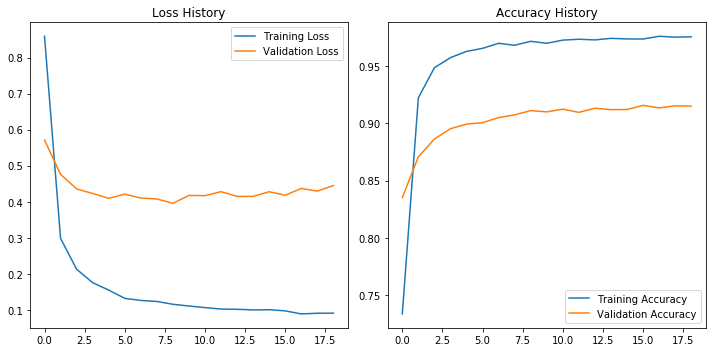

In [106]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### Evaluating the model

In [107]:
trans_model.evaluate(trans_X_test, trans_Y_test)

7209/7209 [==============================] - 1s 77us/step


[0.39561133135262844, 0.911083368012207]

In [108]:
trans_Y_pred = trans_model.predict(trans_X_test)
trans_Y_pred_classes = np.argmax(trans_Y_pred, axis=1)
print(classification_report(trans_Y_test, trans_Y_pred_classes, digits=3))

              precision    recall  f1-score   support

           0      0.907     0.999     0.951      3335
           1      0.966     0.790     0.869       462
           2      1.000     0.739     0.850       425
           3      0.863     0.896     0.879       499
           4      0.900     0.928     0.914       389
           5      0.898     0.805     0.849       394
           6      0.878     0.884     0.881       455
           7      0.901     0.832     0.865       370
           8      1.000     0.796     0.886       421
           9      0.886     0.845     0.865       459

    accuracy                          0.911      7209
   macro avg      0.920     0.851     0.881      7209
weighted avg      0.914     0.911     0.909      7209



#### Correctly classified samples

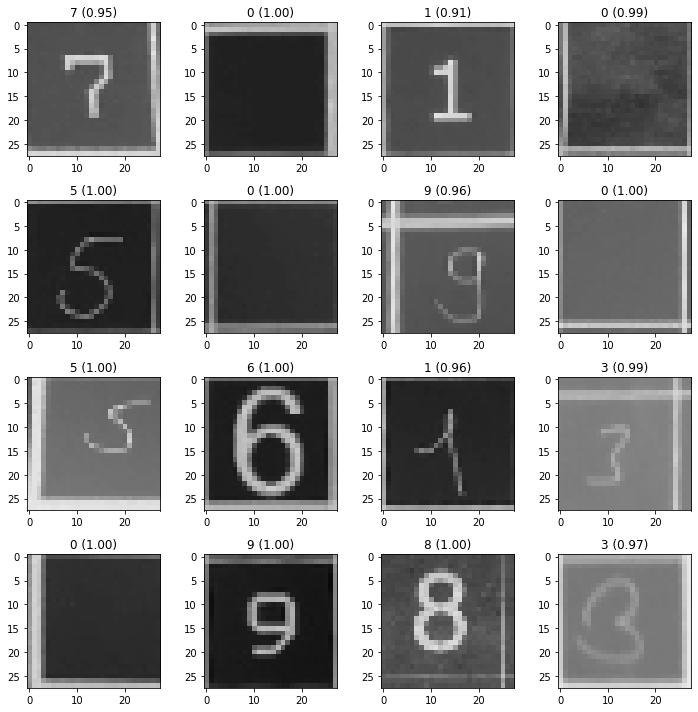

In [112]:
correct_examples = trans_Y_pred_classes == trans_Y_test
show_images(trans_X_test[correct_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in trans_Y_pred[correct_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Incorrectly classified samples

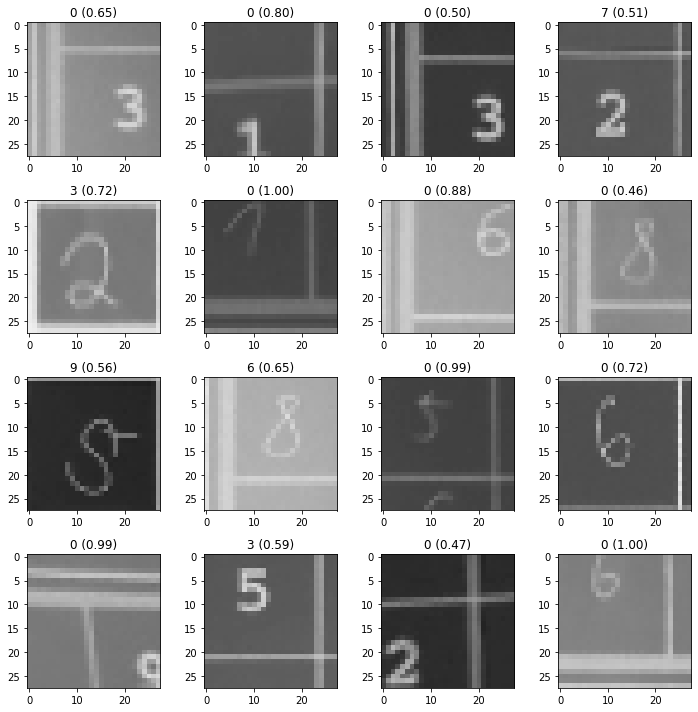

In [111]:
incorrect_examples = trans_Y_pred_classes != trans_Y_test
show_images(trans_X_test[incorrect_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in trans_Y_pred[incorrect_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

## Ensemble Learning

We train multiple small models and later average their outputs to get a better prediction than that of any single one of the original models.

In [114]:
def mm_build_model():
  sudnn_model = model_input = layers.Input(shape=(28, 28, 1))

  sudnn_model = layers.Conv2D(8, 3, activation="relu")(sudnn_model)
  sudnn_model = layers.BatchNormalization()(sudnn_model)
  sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
  sudnn_model = layers.GlobalMaxPool2D()(sudnn_model)
  sudnn_model = layers.BatchNormalization()(sudnn_model)
  sudnn_model = layers.Dropout(0.25)(sudnn_model)

  # sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
  # sudnn_model = layers.BatchNormalization()(sudnn_model)
  # sudnn_model = layers.Conv2D(10, 3, activation="relu")(sudnn_model)
  # sudnn_model = layers.GlobalMaxPool2D()(sudnn_model)
  # sudnn_model = layers.BatchNormalization()(sudnn_model)
  #sudnn_model = layers.Dropout(0.25)(sudnn_model)

  #model = layers.Flatten()(model)
  #model = layers.Dense(32, activation="relu")(model)
  #model = layers.BatchNormalization()(model)
  sudnn_model = layers.Dense(10, activation="softmax")(sudnn_model)
  sudnn_model = models.Model(model_input, sudnn_model)
  sudnn_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

  return sudnn_model

def mm_fit_model(model, train, test):
  early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  fit_history = model.fit(*train, validation_data=test, 
                          epochs=100, callbacks=[early_stopping], 
                          class_weight=class_weight)
  return fit_history

mm_n_models = 10
mm_models = []
for i in range(mm_n_models):
  print("Fitting model %d of %d..." % (i + 1, mm_n_models))
  model = mm_build_model()
  mm_fit_model(model, (sudnn_X_train, sudnn_Y_train), (sudnn_X_test, sudnn_Y_test))
  mm_models.append(model)

Fitting model 1 of 10...
Train on 10449 samples, validate on 7209 samples
Epoch 1/100
10449/10449 [==============================] - 5s 525us/step - loss: 1.4664 - acc: 0.5409 - val_loss: 1.0730 - val_acc: 0.6453
Epoch 2/100
10449/10449 [==============================] - 2s 234us/step - loss: 0.7539 - acc: 0.7861 - val_loss: 0.7819 - val_acc: 0.7524
Epoch 3/100
10449/10449 [==============================] - 3s 240us/step - loss: 0.5397 - acc: 0.8467 - val_loss: 0.7024 - val_acc: 0.7840
Epoch 4/100
10449/10449 [==============================] - 3s 242us/step - loss: 0.4286 - acc: 0.8735 - val_loss: 0.6869 - val_acc: 0.7857
Epoch 5/100
10449/10449 [==============================] - 3s 253us/step - loss: 0.3689 - acc: 0.8888 - val_loss: 0.4965 - val_acc: 0.8599
Epoch 6/100
10449/10449 [==============================] - 3s 254us/step - loss: 0.3281 - acc: 0.8970 - val_loss: 0.5785 - val_acc: 0.8141
Epoch 7/100
10449/10449 [==============================] - 3s 266us/step - loss: 0.3115 - ac

In [0]:
mm_Y_pred = [model.predict(sudnn_X_test) for model in mm_models]

In [0]:
mm_Y_pred_ensemble = np.mean(mm_Y_pred, axis=0)
mm_Y_pred_ensemble_classes = np.argmax(mm_Y_pred_ensemble, axis=1)

In [117]:
print(classification_report(sudnn_Y_test, mm_Y_pred_ensemble_classes, digits=3))

              precision    recall  f1-score   support

           0      0.975     0.998     0.986      3335
           1      0.948     0.916     0.932       462
           2      0.893     0.880     0.886       425
           3      0.850     0.908     0.878       499
           4      0.941     0.910     0.925       389
           5      0.933     0.711     0.807       394
           6      0.907     0.791     0.845       455
           7      0.881     0.941     0.910       370
           8      0.748     0.893     0.814       421
           9      0.808     0.749     0.777       459

    accuracy                          0.921      7209
   macro avg      0.888     0.870     0.876      7209
weighted avg      0.922     0.921     0.920      7209



Although each individual model only has an accuracy of about 80% the ensemble classifier reaches an accuracy of about 92%.

#### Correctly classified samples

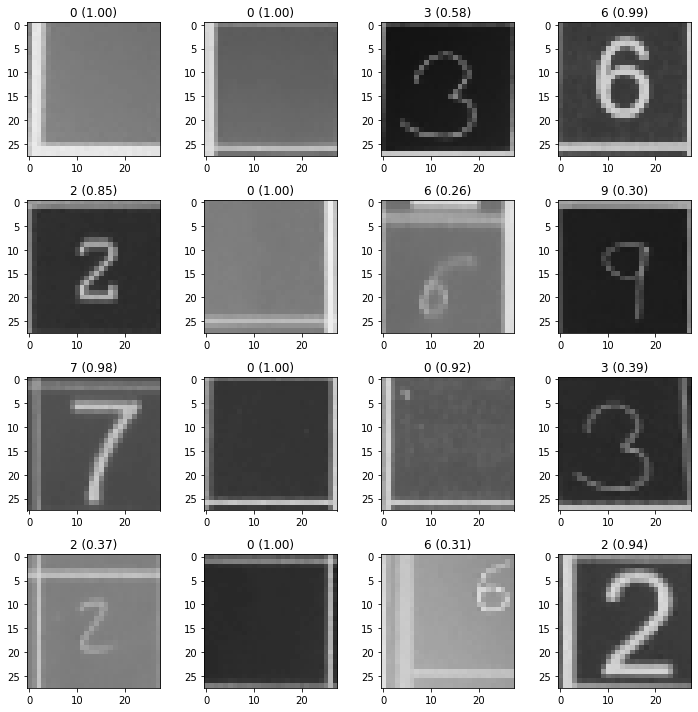

In [118]:
correct_examples = mm_Y_pred_ensemble_classes == sudnn_Y_test
show_images(sudnn_X_test[correct_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in mm_Y_pred_ensemble[correct_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Incorrectly classified samples

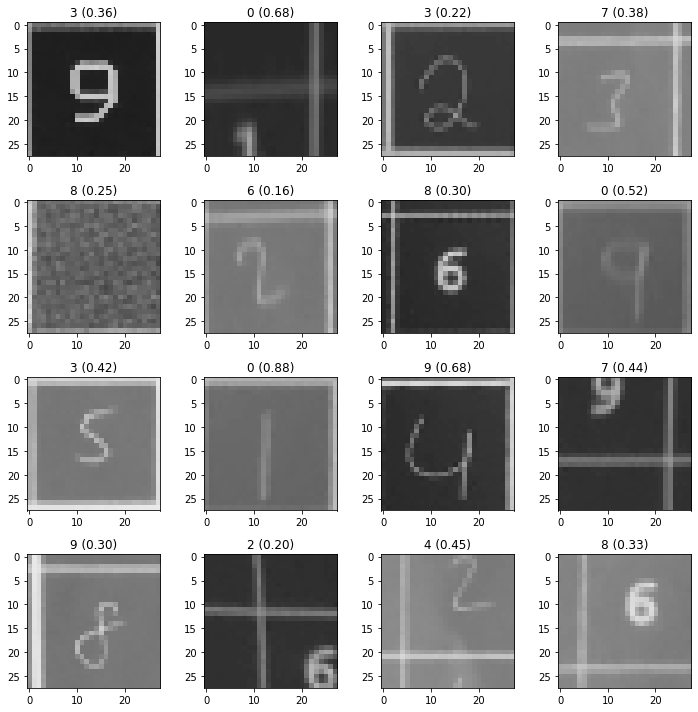

In [119]:
incorrect_examples = mm_Y_pred_ensemble_classes != sudnn_Y_test
show_images(sudnn_X_test[incorrect_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in mm_Y_pred_ensemble[incorrect_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

# Predictions

We have decided to use the "Augmented Sudoku Dataset" model for the recognition of digits as it gave us the best accuracy.

In [120]:
x = [plainmnist_preprocess(cell) for cell in dataset["cell_image"]]
x = np.array(x)
x.shape

(17658, 28, 28, 1)

In [121]:
dataset["recog_x"] = x.tolist()
dataset["recog_x"]

input_filename                                                         cell_row  cell_col
./v2_train/image1066.jpg                                               0         0           [[[0.7819253206253052], [0.8023571968078613], ...
                                                                                 1           [[[0.7680047154426575], [0.7727128267288208], ...
                                                                                 2           [[[0.7785589694976807], [0.77138352394104], [0...
                                                                                 3           [[[0.8188650608062744], [0.7931247353553772], ...
                                                                                 4           [[[0.7862745523452759], [0.7933723330497742], ...
                                                                                                                   ...                        
./sudoku_dataset_1024/train_247994761_full/IMG_20200

In [122]:
y = augsud_model.predict(x)
y.shape

(17658, 10)

In [123]:
dataset["recog_y"] = y.tolist()
dataset["recog_y"]

input_filename                                                         cell_row  cell_col
./v2_train/image1066.jpg                                               0         0           [5.072461548016882e-11, 0.9999990463256836, 2....
                                                                                 1           [0.9999911785125732, 6.126177964915769e-08, 7....
                                                                                 2           [0.9999909400939941, 1.5790435270446324e-07, 9...
                                                                                 3           [0.9999436140060425, 8.41800670059456e-07, 1.5...
                                                                                 4           [0.9999923706054688, 9.628177366494128e-08, 1....
                                                                                                                   ...                        
./sudoku_dataset_1024/train_247994761_full/IMG_20200

In [124]:
digit = np.argmax(y, axis=1)
digit.shape

(17658,)

In [125]:
dataset["recog_digit"] = digit.tolist()
dataset["recog_digit"]

input_filename                                                         cell_row  cell_col
./v2_train/image1066.jpg                                               0         0           1
                                                                                 1           0
                                                                                 2           0
                                                                                 3           0
                                                                                 4           0
                                                                                            ..
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165420778.jpg  8         4           3
                                                                                 5           6
                                                                                 6           3
                                                       

# Export

We are exporting the prediction input `recog_x`, output `recog_y` and the most probable digit class `recog_digit`. 

In [126]:
df = dataset[["recog_x", "recog_y", "recog_digit"]]
df

recog_x  ... recog_digit
input_filename                                     cell_row cell_col                                                     ...            
./v2_train/image1066.jpg                           0        0         [[[0.7819253206253052], [0.8023571968078613], ...  ...           1
                                                            1         [[[0.7680047154426575], [0.7727128267288208], ...  ...           0
                                                            2         [[[0.7785589694976807], [0.77138352394104], [0...  ...           0
                                                            3         [[[0.8188650608062744], [0.7931247353553772], ...  ...           0
                                                            4         [[[0.7862745523452759], [0.7933723330497742], ...  ...           0
...                                                                                                                 ...  ...         ...
./sudoku_dataset_1024/train_247994761_full/IMG_... 8        4         [[[0.31910640001296997], [0.31970661878585815]...  ...           3
                                                            5         [[[0.30957135558128357], [0.32087087631225586]...  ...           6
                                                            6         [[[0.40741172432899475], [0.4083595871925354],...  ...           3
                                                            7         [[[0.3238820433616638], [0.35426172614097595],...  ...           7
                                                            8         [[[0.5234681367874146], [0.4145033359527588], ...  ...           8

[17658 rows x 3 columns]

In [0]:
df.to_pickle("./sudoku_recognition_output.bz2")

In [0]:
!cp "./sudoku_recognition_output.bz2" "./drive/My Drive/sudoku_recognition_output.bz2"